In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import Counter

import copy
from facenet_pytorch import InceptionResnetV1

In [11]:
plt.ion()   # interactive mode

data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(299),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = 'data'
image_datasets = datasets.ImageFolder(data_dir,data_transforms)

dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=16, shuffle=True, num_workers=4)
dataset_sizes = len(image_datasets) 

class_names = image_datasets.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using " + str(device))


Using cuda
['daniele_positive', 'klara_positive', 'negatives']


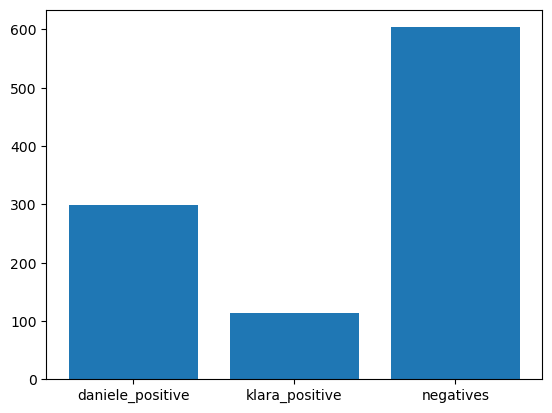

In [3]:
data = dict(Counter(image_datasets.targets))

names = list(image_datasets.classes)
values = list(data.values())

plt.bar(range(len(data)), values, tick_label=names)
plt.show()

In [4]:
next(iter(dataloaders))[0].shape

torch.Size([16, 3, 299, 299])

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(5)  # pause a bit so that plots are updated

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model.train()
    model = model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_accuracy = 0.0

        for inputs, labels in dataloaders:

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            scheduler.step()

            loss = loss.item() # detach gradient

            preds = torch.argmax(outputs, dim=1) 
            corrects = torch.sum(preds == labels)

            running_accuracy += corrects
            running_loss += loss

        running_loss /= dataset_sizes
        running_accuracy /= dataset_sizes
        print(f"loss = {running_loss} accuracy = {running_accuracy}")

        if running_accuracy > best_acc:
            best_acc = running_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [6]:
model_ft = InceptionResnetV1(pretrained='vggface2', device=device, classify= True, num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

model_path = "trained_model.pt"
print("Saving model "+model_path)
torch.save(model_ft.state_dict(), model_path)

Epoch 0/19
----------
loss = 0.03952759504318237 accuracy = 0.7588582634925842

Epoch 1/19
----------
loss = 0.03593164418758018 accuracy = 0.7913385629653931

Epoch 2/19
----------
loss = 0.036608382707505716 accuracy = 0.7726377844810486

Epoch 3/19
----------
loss = 0.035883671846094096 accuracy = 0.7962598204612732

Epoch 4/19
----------
loss = 0.035817381962547155 accuracy = 0.7765747904777527

Epoch 5/19
----------
loss = 0.030989433602085264 accuracy = 0.7972440719604492

Epoch 6/19
----------
loss = 0.03394229818634161 accuracy = 0.7913385629653931

Epoch 7/19
----------
loss = 0.03585609739396985 accuracy = 0.7805117964744568

Epoch 8/19
----------
loss = 0.032051577709439234 accuracy = 0.8169291019439697

Epoch 9/19
----------
loss = 0.03542209250896465 accuracy = 0.7795275449752808

Epoch 10/19
----------
loss = 0.035896394636452666 accuracy = 0.7923228144645691

Epoch 11/19
----------
loss = 0.035166998122503436 accuracy = 0.7706692814826965

Epoch 12/19
----------
loss = 0

In [10]:
import cv2
from PIL import Image

checkpoint = torch.load('trained_model.pt')
model_ft.load_state_dict(checkpoint)

vc = cv2.VideoCapture(0)
model_ft.eval()
while True:
    ret, frame = vc.read()
    if not ret:
        print("Error reading frame from video capture.")
        break
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    frame = data_transforms(pil_image).unsqueeze(0).to(device)
    res = model_ft(frame)
    m = torch.argmax(res.detach())
    print(class_names[m])

Error reading frame from video capture.


[ WARN:0@1479.861] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@1479.862] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range
